In [9]:
import lzma
import json

import pandas as pd
from geopy.geocoders import GoogleV3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import isnull
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import langid
import nltk

# Read processed event data

In [10]:
job_ad_extend_coord_df = pd.read_csv("job_ad_extend_coord_df.csv",index_col=0)
event_data_dedup_df = pd.read_csv("data/event_data_dedup_df.csv",index_col=0)

In [8]:
job_ad_extend_coord_df[job_ad_extend_coord_df["id"] == 38922293]

,id,title,abstract,content,additionalSalaryText,standout.bullet1,standout.bullet2,standout.bullet3,classification,subClassification,...,state,country,cleaned_content,abstract_content,cleaned_title,is_english,title_keywords,keywords,salary_value,salary_unit
22262,38922293,Other,Our Client based in Mascot is seeking sorters ...,<HTML><p>Our client based in Mascot is seeking...,$24 - $25 p.h.,Process Workers Needed,Food Industry Knowledge a MUST!,Mascot Location,Retail & Consumer Products,Other,...,NSW,Australia,Our client based in Mascot is seeking sorters ...,client mascot seeking sorter dispatch food pro...,NaN,True,"area manager, assistant manager","team player, assistant manager, assistant stor...",24.5,year


In [134]:
job_ad_extend_coord_df.columns

Index(['id', 'title', 'abstract', 'content', 'additionalSalaryText',
       'standout.bullet1', 'standout.bullet2', 'standout.bullet3',
       'classification', 'subClassification', 'workType', 'area_location',
       'address', 'Latitude', 'Longitude', 'global', 'state', 'country',
       'cleaned_content', 'abstract_content', 'cleaned_title', 'is_english',
       'title_keywords', 'keywords', 'salary_value', 'salary_unit'],
      dtype='object')

In [11]:
job_ad_extend_coord_df = job_ad_extend_coord_df[['id', 'title', 'abstract', 'content', 'additionalSalaryText',
       'classification', 'subClassification', 'workType', 'area_location',
       'address', 'Latitude', 'Longitude', 'global', 'state', 'country',
       'cleaned_content', 'abstract_content',
       'salary_value', 'salary_unit']]

In [12]:
job_event_join_df = event_data_dedup_df.merge(job_ad_extend_coord_df, left_on='job_id', right_on='id', how='inner')

In [37]:
event_data_pivot_kind_df = (
    job_event_join_df.groupby(["resume_id", "kind"])["event_datetime"].count()
    .reset_index()
    .pivot(index='resume_id', columns='kind', values='event_datetime')
    .reset_index()
    .rename_axis(None, axis=1)  # Remove the axis name (kind)
    .sort_values(by=["V"], ascending=False)
)
event_data_pivot_kind_df.loc[:, "A"] = event_data_pivot_kind_df["A"].fillna(0)
event_data_pivot_kind_df['A'] = event_data_pivot_kind_df['A'].astype(int)
event_data_pivot_kind_df.loc[:, "V"] = event_data_pivot_kind_df["V"].fillna(0)
event_data_pivot_kind_df['V'] = event_data_pivot_kind_df['V'].astype(int)
event_data_pivot_kind_df['diff'] = event_data_pivot_kind_df['V'] - event_data_pivot_kind_df['A']

In [39]:
event_data_pivot_kind_df['diff_percentage'] = (event_data_pivot_kind_df['V'] - event_data_pivot_kind_df['A'])/(event_data_pivot_kind_df['V'] + event_data_pivot_kind_df['A'])

       resume_id  center_latitude  center_longitude
0              1       -33.008174        148.259604
1              2       -32.495584        143.590070
2              3       -31.844335        147.249884
3              4       -33.341347        146.521079
4              5       -34.503972        149.223277
...          ...              ...               ...
29413     438636       -34.928499        138.600746
29414     438685       -33.571679        146.711498
29415     438904       -35.824565        147.978813
29416     439309       -34.090946        147.899086
29417     439329       -34.561739        141.735420

[29418 rows x 3 columns]


In [40]:
event_data_pivot_kind_df.head()

,resume_id,A,V,diff,diff_percentage
211,245,915,2418,1503,0.450945
4740,6517,547,1834,1287,0.540529
3364,4456,109,1820,1711,0.886988
851,1099,0,1707,1707,1.000000
3770,5046,97,1611,1514,0.886417


In [8]:
job_event_join_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423733 entries, 0 to 1423732
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   event_datetime        1423733 non-null  object 
 1   resume_id             1423733 non-null  int64  
 2   job_id                1423733 non-null  int64  
 3   event_platform        1423733 non-null  object 
 4   kind                  1423733 non-null  object 
 5   id                    1423733 non-null  int64  
 6   title                 1423733 non-null  object 
 7   abstract              1423733 non-null  object 
 8   content               1423733 non-null  object 
 9   additionalSalaryText  467966 non-null   object 
 10  standout.bullet1      685874 non-null   object 
 11  standout.bullet2      683415 non-null   object 
 12  standout.bullet3      665188 non-null   object 
 13  classification        1423733 non-null  object 
 14  subClassification     1423733 non-

In [48]:
from scipy.spatial import ConvexHull

In [49]:
job_event_join_df.columns

Index(['event_datetime', 'resume_id', 'job_id', 'event_platform', 'kind', 'id',
       'title', 'abstract', 'content', 'additionalSalaryText',
       'standout.bullet1', 'standout.bullet2', 'standout.bullet3',
       'classification', 'subClassification', 'workType', 'area_location',
       'address', 'Latitude', 'Longitude', 'global', 'state', 'country',
       'cleaned_content', 'abstract_content', 'keywords', 'salary_value',
       'salary_unit'],
      dtype='object')

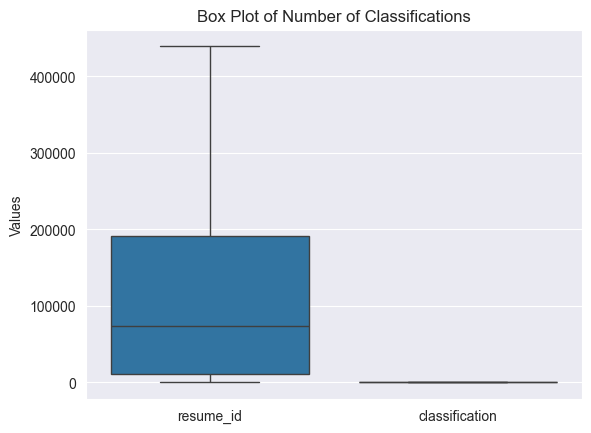

,resume_id,classification
count,29568.000000,29568.000000
mean,119667.393398,12.422179
std,115421.427555,7.474584
min,1.000000,1.000000
25%,10958.750000,6.000000
50%,74311.500000,12.000000
75%,191039.000000,18.000000
max,439329.000000,30.000000


In [119]:
# Most candidates apply jobs for 6-18 different classes, for those who appied more than 18 classes, the user behaviour might be different
classification_number = job_event_join_df.groupby(["resume_id"])["classification"].apply(lambda x: len(set(x))).reset_index()

sns.boxplot(data=classification_number)
plt.title('Box Plot of Number of Classifications')
plt.ylabel('Values')
plt.show()
classification_number.describe()

consider data within Australia only

In [87]:
# def calculate_bounding_box_area(points):
#     """Calculate the area of the bounding box for a set of points."""
#     min_lat, max_lat = points[:, 0].min(), points[:, 0].max()
#     min_lon, max_lon = points[:, 1].min(), points[:, 1].max()
#     return (max_lat - min_lat) * (max_lon - min_lon)
#
#
# data_within_australia = job_event_join_df[(job_event_join_df["global"]==0) & (job_event_join_df["Latitude"] is not None)][['resume_id','Latitude','Longitude']]
# grouped = data_within_australia.groupby("resume_id")
# # Apply the function to each group
# results = grouped.apply(lambda x: calculate_bounding_box_area(x[["Latitude", "Longitude"]].values)).reset_index()
# results.columns = ["resume_id", "area"]

# group1 = results[results["resume_id"].isin(job_event_join_df_grouped[job_event_join_df_grouped["classification"]<=18]["resume_id"].values)]
#
# group2 = results[results["resume_id"].isin(job_event_join_df_grouped[job_event_join_df_grouped["classification"]>18]["resume_id"].values)]
#
# # Create a figure and axis
# fig, ax = plt.subplots()
#
# # Plot box plots for both DataFrames
# ax.boxplot(group1["area"], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# ax.boxplot(group2["area"], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
#
# # Add labels and title
# ax.set_xticks([1, 2])
# ax.set_xticklabels(["<18", ">18"])
# ax.set_ylabel("Values")
# ax.set_title("Box Plot Comparison")
#
# # Show the plot
# plt.show()

C:\Users\annab\AppData\Local\Temp\ipykernel_10708\3125089781.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = grouped.apply(lambda x: calculate_bounding_box_area(x[["Latitude", "Longitude"]].values)).reset_index()


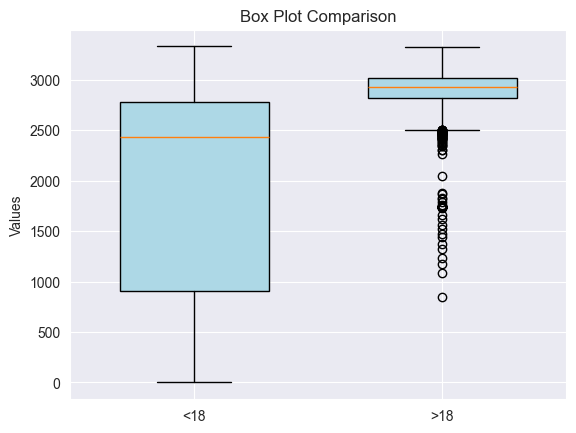

In [120]:
# Haversine formula to calculate distance between two points on Earth
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    :param lat1, lon1: Latitude and longitude of point 1 (in degrees).
    :param lat2, lon2: Latitude and longitude of point 2 (in degrees).
    :return: Distance in kilometers.
    """
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance
data_within_australia = job_event_join_df[(job_event_join_df["global"]==0) & (job_event_join_df["Latitude"] is not None)]
centroids = data_within_australia.groupby("resume_id")[["Latitude", "Longitude"]].mean().reset_index()
centroids.columns = ["resume_id", "center_latitude", "center_longitude"]
# Merge centroids with the original DataFrame
data_within_australia = data_within_australia.merge(centroids, on="resume_id")

# Calculate distance to the center for each location
data_within_australia["distance_to_center"] = data_within_australia.apply(
    lambda row: haversine(row["Latitude"], row["Longitude"], row["center_latitude"], row["center_longitude"]),
    axis=1
)
# Find the farthest distance for each candidate
farthest_distances = data_within_australia.groupby("resume_id")["distance_to_center"].agg(['max', 'min', 'mean', 'std']).reset_index()
farthest_distances.columns = ["resume_id", "farthest_distance_to_center_km","shortest_distance_to_center_km","average_distance_to_center_km","std_distance_to_center_km"]


group1 = farthest_distances[farthest_distances["resume_id"].isin(classification_number[classification_number["classification"]<=18]["resume_id"].values)]

group2 = farthest_distances[farthest_distances["resume_id"].isin(classification_number[classification_number["classification"]>18]["resume_id"].values)]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot box plots for both DataFrames
ax.boxplot(group1["farthest_distance_to_center_km"], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group2["farthest_distance_to_center_km"], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Add labels and title
ax.set_xticks([1, 2])
ax.set_xticklabels(["<18", ">18"])
ax.set_ylabel("Values")
ax.set_title("Box Plot Comparison")

# Show the plot
plt.show()


In [89]:
job_event_join_df.columns

Index(['event_datetime', 'resume_id', 'job_id', 'event_platform', 'kind', 'id',
       'title', 'abstract', 'content', 'additionalSalaryText',
       'standout.bullet1', 'standout.bullet2', 'standout.bullet3',
       'classification', 'subClassification', 'workType', 'area_location',
       'address', 'Latitude', 'Longitude', 'global', 'state', 'country',
       'cleaned_content', 'abstract_content', 'keywords', 'salary_value',
       'salary_unit'],
      dtype='object')

workType
Casual/Vacation     93954
Contract/Temp      240937
Full Time          996530
Part Time           92312
Name: resume_id, dtype: int64


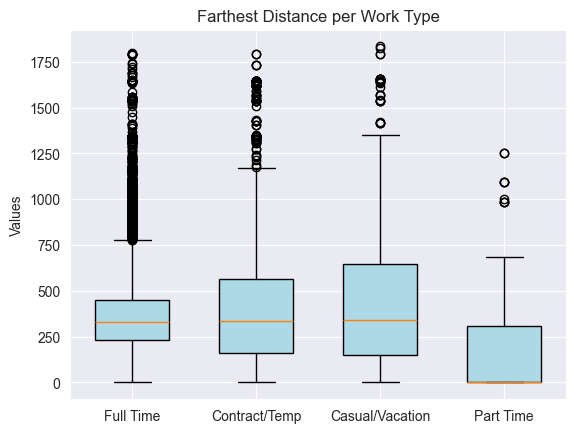

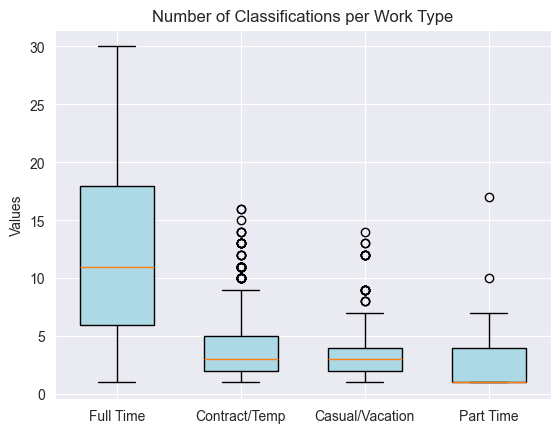

In [132]:
# most frequent work type
most_frequent_kind = data_within_australia.groupby("resume_id")["workType"].apply(lambda x: x.mode()[0]).reset_index()
print(job_event_join_df.groupby("workType")["resume_id"].count())
group1 = farthest_distances[farthest_distances["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=='Full Time']["resume_id"].values)]

group2 = farthest_distances[farthest_distances["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=="Contract/Temp"]["resume_id"].values)]
group3 = farthest_distances[farthest_distances["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=='Casual/Vacation']["resume_id"].values)]

group4 = farthest_distances[farthest_distances["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=="Part Time"]["resume_id"].values)]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot box plots for both DataFrames
ax.boxplot(group1["shortest_distance_to_center_km"], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group2["shortest_distance_to_center_km"], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group3["shortest_distance_to_center_km"], positions=[3], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group4["shortest_distance_to_center_km"], positions=[4], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# Add labels and title
ax.set_xticks([1, 2,3,4])
ax.set_xticklabels(["Full Time", "Contract/Temp", "Casual/Vacation", "Part Time"])
ax.set_ylabel("Values")
ax.set_title("Farthest Distance per Work Type")

# Show the plot
plt.show()

classification_number = data_within_australia.groupby(["resume_id"])["classification"].apply(lambda x: len(set(x)))
classification_number = classification_number.reset_index()


group1 = classification_number[classification_number["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=='Full Time']["resume_id"].values)]

group2 = classification_number[classification_number["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=="Contract/Temp"]["resume_id"].values)]
group3 = classification_number[classification_number["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=='Casual/Vacation']["resume_id"].values)]

group4 = classification_number[classification_number["resume_id"].isin(most_frequent_kind[most_frequent_kind["workType"]=="Part Time"]["resume_id"].values)]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot box plots for both DataFrames
ax.boxplot(group1["classification"], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group2["classification"], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group3["classification"], positions=[3], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
ax.boxplot(group4["classification"], positions=[4], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# Add labels and title
ax.set_xticks([1, 2,3,4])
ax.set_xticklabels(["Full Time", "Contract/Temp", "Casual/Vacation", "Part Time"])
ax.set_ylabel("Values")
ax.set_title("Number of Classifications per Work Type")

# Show the plot
plt.show()



In [126]:
farthest_distances.columns

Index(['resume_id', 'farthest_distance_to_center_km',
       'shortest_distance_to_center_km', 'average_distance_to_center_km',
       'std_distance_to_center_km'],
      dtype='object')

In [130]:
def draw_box_plot(group_data,column_name,group_name,title):
    fig, ax = plt.subplots()
    for idx,group in enumerate(group_data):
        ax.boxplot(group[column_name], positions=[idx+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    # Add labels and title
    ax.set_xticks(list(range(len(group_data))))
    ax.set_xticklabels(group_name)
    ax.set_ylabel("Values")
    ax.set_title(title)
    plt.show()

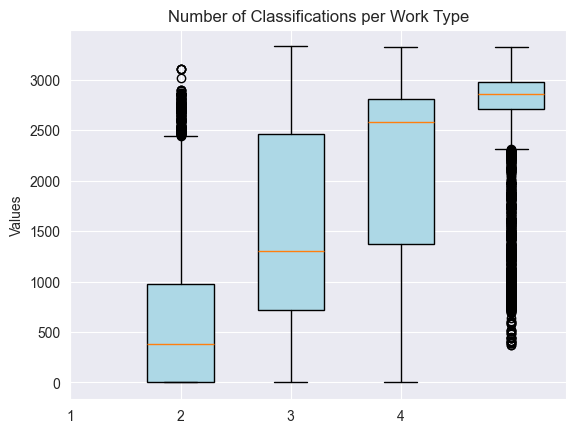

In [131]:
# number of work type
num_of_kind = data_within_australia.groupby("resume_id")["workType"].apply(lambda x: len(set(x))).reset_index()

group1 = farthest_distances[farthest_distances["resume_id"].isin(num_of_kind[num_of_kind["workType"]==1]["resume_id"].values)]

group2 = farthest_distances[farthest_distances["resume_id"].isin(num_of_kind[num_of_kind["workType"]==2]["resume_id"].values)]
group3 = farthest_distances[farthest_distances["resume_id"].isin(num_of_kind[num_of_kind["workType"]==3]["resume_id"].values)]

group4 = farthest_distances[farthest_distances["resume_id"].isin(num_of_kind[num_of_kind["workType"]==4]["resume_id"].values)]

draw_box_plot([group1,group2,group3,group4],"farthest_distance_to_center_km",[1,2,3,4],"Number of Classifications per Work Type")
# # Create a figure and axis
# fig, ax = plt.subplots()
#
# # Plot box plots for both DataFrames
# ax.boxplot(group1["farthest_distance_to_center_km"], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# ax.boxplot(group2["farthest_distance_to_center_km"], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# ax.boxplot(group3["farthest_distance_to_center_km"], positions=[3], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# ax.boxplot(group4["farthest_distance_to_center_km"], positions=[4], widths=0.6, patch_artist=True, boxprops=dict(facecolor="lightblue"))
# # Add labels and title
# ax.set_xticks([1, 2,3,4])
# ax.set_xticklabels(["1", "2", "3", "4"])
# ax.set_ylabel("Values")
# ax.set_title("Number of Classifications per Work Type")
#
# # Show the plot
# plt.show()
# # number of platform


,resume_id,classification
0,1,15
1,2,21
2,3,5
3,4,14
4,5,11
...,...,...
29563,438636,3
29564,438685,10
29565,438904,2
29566,439309,5


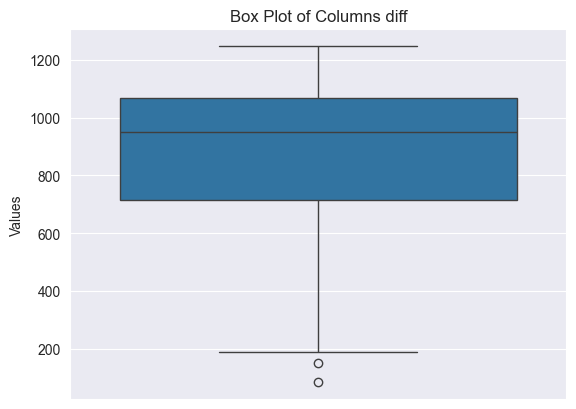

In [64]:
sns.boxplot(data=group2['area'])
plt.title('Box Plot of Columns diff')
plt.ylabel('Values')
plt.show()

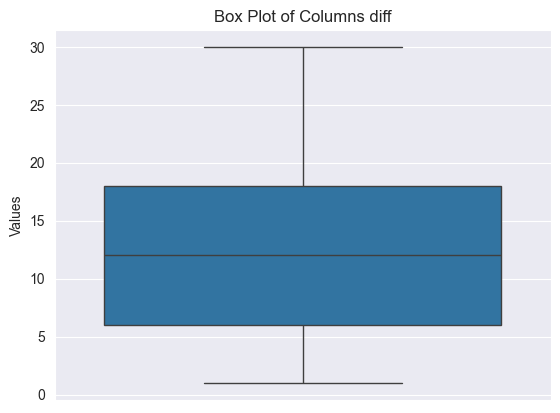

count    29568.000000
mean        12.422179
std          7.474584
min          1.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         30.000000
Name: classification, dtype: float64

In [24]:
job_event_join_df_grouped = job_event_join_df_grouped.reset_index()


In [41]:
group1 = event_data_pivot_kind_df[event_data_pivot_kind_df["resume_id"].isin(job_event_join_df_grouped[job_event_join_df_grouped["classification"]<=18]["resume_id"].values)]

In [42]:
group2 = event_data_pivot_kind_df[event_data_pivot_kind_df["resume_id"].isin(job_event_join_df_grouped[job_event_join_df_grouped["classification"]>18]["resume_id"].values)]

In [47]:
group2["diff_percentage"].describe()

count    6949.000000
mean        0.889149
std         0.244808
min        -1.000000
25%         0.986842
50%         1.000000
75%         1.000000
max         1.000000
Name: diff_percentage, dtype: float64

In [46]:
group1["diff_percentage"].describe()

count    22619.000000
mean         0.926152
std          0.254140
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: diff_percentage, dtype: float64

In [43]:
group1.columns

Index(['resume_id', 'A', 'V', 'diff', 'diff_percentage'], dtype='object')

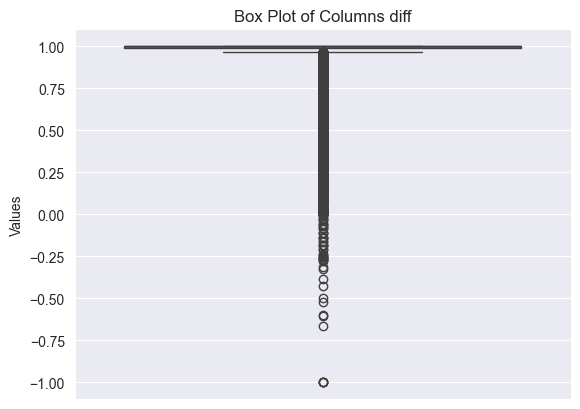

In [44]:
sns.boxplot(data=group2["diff_percentage"])
plt.title('Box Plot of Columns diff')
plt.ylabel('Values')
plt.show()


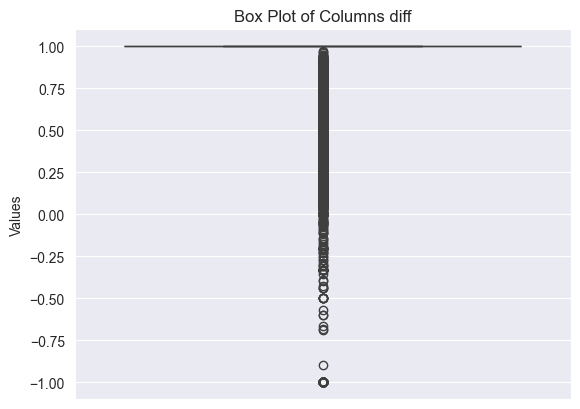

In [45]:
sns.boxplot(data=group1["diff_percentage"])
plt.title('Box Plot of Columns diff')
plt.ylabel('Values')
plt.show()